In [18]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from plotly.subplots import make_subplots
import datetime
import seaborn as sns
import json
import pickle



basepath = r'C:\Users\Joyqiao\Documents\CMU\RA\HIGHMARK Trajectory claim\HIghmark Project'


In [26]:
os.chdir(basepath)

In [27]:
cd data\stata_output

C:\Users\Joyqiao\Documents\CMU\RA\HIGHMARK Trajectory claim\HIghmark Project\data\stata_output


In [28]:
ls

 Volume in drive C is Windows
 Volume Serial Number is BA8F-7F5E

 Directory of C:\Users\Joyqiao\Documents\CMU\RA\HIGHMARK Trajectory claim\HIghmark Project\data\stata_output

01/17/2021  08:40 PM    <DIR>          .
01/17/2021  08:40 PM    <DIR>          ..
01/13/2021  01:01 PM            31,518 3a_12_inpatient.jpg
01/13/2021  01:01 PM           493,462 3a_12_inpatient.xlsx
01/13/2021  01:03 PM           819,900 3a_12_inpatient_probupdates.xlsx
01/13/2021  01:38 PM            44,084 3a_21223_outpatient.jpg
01/13/2021  01:38 PM         2,440,588 3a_21223_outpatient_probupdates.xlsx
01/13/2021  01:31 PM         2,133,788 3a_3223_outpaitent_probupdates.xlsx
01/11/2021  02:39 PM            33,746 3a_331_total.jpg
01/11/2021  02:38 PM           878,483 3a_331_total_2021.xlsx
01/11/2021  02:24 PM           892,448 3a_3331_total_2021.xlsx
01/11/2021  02:35 PM               684 3a_3331_total_2021.xlsx_performance.csv
01/13/2021  12:55 PM            42,938 3a_33331_dropout.jpg
01/11/2021  02:2

In [2]:
#combine claim and clininc dataframe into an aggregated one
def combine_cc_cluster_output(claim_type,stage):
    '''
    claim type: string
    stage string
    '''
    claim = pd.read_excel(basepath+'\\data\\by_clinical_stage\\{}\\{}.xlsx'.format(claim_type,stage))
    clinic = pd.read_csv('{}\Clinical Data\Clinical Data\\by_stage_tma_lists\egfr_{}_group.csv'.format(basepath,stage))
    clinic = clinic[['tma_acct']+[i for i in clinic.columns if re.search(r".*traj.*", i)]]
    data = claim.merge(clinic,on = 'tma_acct',how = 'inner',suffixes = ['_claim','_clinic'])
    return data



In [3]:
#first start with total cost of 3a patients
claim_type = 'total'
stage = '3a'
data = combine_cc_cluster_output(claim_type,stage)

tma = data.tma_acct.unique()

In [4]:
data.head()

tma_acct     cost1     cost2     cost3      cost4     cost5      cost6  \
0       499  5.960644  6.762059  7.464206   5.877764  6.174036   5.329331   
1       757  7.226689  7.090235  8.853191  10.057408  9.007155   9.139664   
2      1025  7.701775  7.734602  6.545522   6.858145  7.419249   7.286356   
3      1088  6.390006  5.953841  5.910363   5.710129  5.851743   4.825590   
4      1150  7.946812  7.839506  7.597537   7.390440  9.806065  10.448871   

       cost7     cost8     cost9  ...  _traj_ProbG1_T35  _traj_ProbG2_T35  \
0   8.370091  6.494540  5.875493  ...      1.031441e-06          0.849483   
1   8.373251  7.670284  8.434759  ...      1.523293e-13          0.000195   
2   7.095520  7.856331  6.683724  ...      9.316128e-14          0.001723   
3   6.045124  6.807858  6.076380  ...      2.386692e-01          0.760396   
4  10.483695       NaN       NaN  ...      2.647780e-09          0.000896   

   _traj_ProbG3_T35  _traj_ProbG4_T35  _traj_ProbG5_T35  _traj_Group_clinic  \
0      3.059060e-02      1.199250e-01      1.468733e-09                   2   
1      1.050971e-10      2.640695e-01      7.357352e-01                   3   
2      2.812670e-02      9.701499e-01      1.255439e-10                   3   
3      9.349004e-04      1.436767e-10      1.275882e-32                   3   
4      7.673575e-08      1.498294e-01      8.492747e-01                   1   

   _traj_ProbG1_clinic  _traj_ProbG2_clinic  _traj_ProbG3_clinic  \
0             0.016114             0.934652             0.049234   
1             0.000048             0.069746             0.832294   
2             0.000125             0.147013             0.843480   
3             0.000070             0.204399             0.794717   
4             0.917459             0.081551             0.000990   

   _traj_ProbG4_clinic  
0         2.621399e-08  
1         9.791269e-02  
2         9.382443e-03  
3         8.143155e-04  
4         4.456977e-09  

[5 rows x 380 columns]

In [5]:
# get cluster-tma-map
A = dict(tuple(data.groupby('_traj_Group_claim')['tma_acct']))

def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
save_obj(A, basepath+'\\data\\3a_tma_cluster_dict' )


A.keys()


dict_keys([1, 2, 3, 4, 5])

In [6]:
def exponetiate_df(data):
        # exponetial back the original cost
    global cost_columns
    cost_columns = [i for i in data.columns if re.search(r'cost',i)]
    
    
    data[cost_columns] = data[cost_columns].apply(np.exp)    
    return data


def extract_total_claim_type_cost(cluster_dict,data,selected_cluster,type_name):
    '''
    cluster dict: dict cluster number -- tma number
    data: df  claim type cost data
    selected_cluster: int
    type-name: specify claim type name str
    '''
    name = 'total_cost'+'_'+type_name
    '''to get the total cost'''
    #data[name] = data[cost_columns].sum(axis = 1)
    #target_cost = data.loc[data['tma_acct'].isin(cluster_dict[selected_cluster]),['tma_acct',name]]
    '''to get the by time cost'''
    
    target_cost = data.loc[data['tma_acct'].isin(cluster_dict[selected_cluster]),['tma_acct']+cost_columns]
    target_cost.rename(columns = dict(zip(cost_columns,[name+'_'+i for i in cost_columns])),inplace = True)
    target_cost['cluster'] = selected_cluster

    return target_cost



In [7]:
cd C:\Users\Joyqiao\Documents\CMU\RA\HIGHMARK Trajectory claim\HIghmark Project\data\stata_output

C:\Users\Joyqiao\Documents\CMU\RA\HIGHMARK Trajectory claim\HIghmark Project\data\stata_output


In [10]:
ls

 Volume in drive C is Windows
 Volume Serial Number is BA8F-7F5E

 Directory of C:\Users\Joyqiao\Documents\CMU\RA\HIGHMARK Trajectory claim\HIghmark Project\data\stata_output

01/17/2021  08:40 PM    <DIR>          .
01/17/2021  08:40 PM    <DIR>          ..
01/13/2021  01:01 PM            31,518 3a_12_inpatient.jpg
01/13/2021  01:01 PM           493,462 3a_12_inpatient.xlsx
01/13/2021  01:03 PM           819,900 3a_12_inpatient_probupdates.xlsx
01/13/2021  01:38 PM            44,084 3a_21223_outpatient.jpg
01/13/2021  01:38 PM         2,440,588 3a_21223_outpatient_probupdates.xlsx
01/13/2021  01:31 PM         2,133,788 3a_3223_outpaitent_probupdates.xlsx
01/11/2021  02:39 PM            33,746 3a_331_total.jpg
01/11/2021  02:38 PM           878,483 3a_331_total_2021.xlsx
01/11/2021  02:24 PM           892,448 3a_3331_total_2021.xlsx
01/11/2021  02:35 PM               684 3a_3331_total_2021.xlsx_performance.csv
01/13/2021  12:55 PM            42,938 3a_33331_dropout.jpg
01/11/2021  02:2

In [8]:
#intialize 
diff_type_cost = pd.DataFrame()
diff_type_cost['tma_acct'] = tma
for excel in ['3a_inpatient_32.xlsx','3a_outpatient_3223.xlsx','3a_drug_31233.xlsx','3a_professional_3213.xlsx']:
    data =  pd.read_excel(basepath+'\\data\\stata_output\\'+excel)
    data = exponetiate_df(data)
    diff_cluster_cost = pd.DataFrame()

    for i in list(A.keys()):
        diff_cluster_cost = pd.concat([diff_cluster_cost,extract_total_claim_type_cost(A,data,i,re.search('^(.*)(_{1})(\w*)',excel).group(1))])
    diff_type_cost = diff_type_cost.merge(diff_cluster_cost,on = 'tma_acct',how = 'left')
    


In [9]:
for i in diff_type_cost.columns:
    print(i)

tma_acct
total_cost_3a_inpatient_cost1
total_cost_3a_inpatient_cost2
total_cost_3a_inpatient_cost3
total_cost_3a_inpatient_cost4
total_cost_3a_inpatient_cost5
total_cost_3a_inpatient_cost6
total_cost_3a_inpatient_cost7
total_cost_3a_inpatient_cost8
total_cost_3a_inpatient_cost9
total_cost_3a_inpatient_cost10
total_cost_3a_inpatient_cost11
total_cost_3a_inpatient_cost12
total_cost_3a_inpatient_cost13
total_cost_3a_inpatient_cost14
total_cost_3a_inpatient_cost15
total_cost_3a_inpatient_cost16
total_cost_3a_inpatient_cost17
total_cost_3a_inpatient_cost18
total_cost_3a_inpatient_cost19
total_cost_3a_inpatient_cost20
total_cost_3a_inpatient_cost21
total_cost_3a_inpatient_cost22
total_cost_3a_inpatient_cost23
total_cost_3a_inpatient_cost24
total_cost_3a_inpatient_cost25
total_cost_3a_inpatient_cost26
total_cost_3a_inpatient_cost27
total_cost_3a_inpatient_cost28
total_cost_3a_inpatient_cost29
total_cost_3a_inpatient_cost30
total_cost_3a_inpatient_cost31
total_cost_3a_inpatient_cost32
total_co

In [12]:
diff_type_cost = diff_type_cost.drop(columns = 'cluster_x')
diff_type_cost =diff_type_cost.iloc[:,:-1]

In [13]:
sum(diff_type_cost.cluster_y == np.nan)

0

In [14]:
diff_type_cost.cluster_y.value_counts()

4.0    288
2.0    235
5.0    130
1.0     97
3.0     86
Name: cluster_y, dtype: int64

In [ ]:
# frequency of top 5/10 codes for all treatment
#most common inpatient diagnosis
#what drives the cost of cluster 5 also the 3 

inpatient cost

In [19]:
B

total_cost_3a_inpatient_cost1  total_cost_3a_inpatient_cost2  \
cluster_y                                                                 
1.0                          5180.162800                    4733.122231   
2.0                         10416.910972                   10762.468696   
3.0                          7001.554962                    5198.220548   
4.0                         18893.320525                   15207.142695   
5.0                         14888.745465                   19385.136781   

           total_cost_3a_inpatient_cost3  total_cost_3a_inpatient_cost4  \
cluster_y                                                                 
1.0                         20338.134694                            NaN   
2.0                         16623.308621                   12749.298937   
3.0                         25089.426520                   41050.747154   
4.0                         20360.651918                   11406.172854   
5.0                         30874.793330                   15955.950545   

           total_cost_3a_inpatient_cost5  total_cost_3a_inpatient_cost6  \
cluster_y                                                                 
1.0                         11764.537165                   18086.319061   
2.0                         11596.007182                    8928.765204   
3.0                          7379.974516                   23913.814879   
4.0                         16571.143540                   19097.814333   
5.0                         21685.524459                   22561.326379   

           total_cost_3a_inpatient_cost7  total_cost_3a_inpatient_cost8  \
cluster_y                                                                 
1.0                          8024.160833                    6841.890849   
2.0                         12107.219305                   12707.306179   
3.0                         12533.090464                    9689.319009   
4.0                         17571.423717                   28764.459233   
5.0                         24529.903557                   22246.578879   

           total_cost_3a_inpatient_cost9  total_cost_3a_inpatient_cost10  \
cluster_y                                                                  
1.0                          5892.038924                    10175.919639   
2.0                         11192.416487                    15129.060504   
3.0                         15812.894739                    12570.149580   
4.0                         19509.723905                    20013.037415   
5.0                         12144.764956                    19718.252923   

           total_cost_3a_inpatient_cost11  total_cost_3a_inpatient_cost12  \
cluster_y                                                                   
1.0                          21517.550132                    15645.709102   
2.0                          17023.652097                    21948.281631   
3.0                          12152.876425                    19196.213499   
4.0                          26067.984812                    24607.363564   
5.0                          17852.077544                    19428.274868   

           total_cost_3a_inpatient_cost13  total_cost_3a_inpatient_cost14  \
cluster_y                                                                   
1.0                           9422.818616                             NaN   
2.0                          15815.842821                    19286.840016   
3.0                          13012.639983                    22677.490373   
4.0                          15294.765624                    15270.545227   
5.0                          18455.523868                    14670.835570   

           total_cost_3a_inpatient_cost15  total_cost_3a_inpatient_cost16  \
cluster_y                                                                   
1.0                           8941.816670                     9823.141905   
2.0                          18552.756403                    20

In [46]:


pd.set_option('display.max_column',None)
B = diff_type_cost.groupby('cluster_y').mean().iloc[:,1:]

def visual_cost_traj_by_cluster_by_claimtype(claim_type_str):
    '''claim_type:str'''
    claim_type = B[[i for i in B.columns if re.search(claim_type_str,i)]]
    claim_type = claim_type[[i for i in claim_type.columns if not re.search('37$',i)]]
    for row in range(5):
        plt.plot(['cost'+str(i) for i in range(1,37)], claim_type.iloc[row,:], label = "Cluster {}".format(row+1))
    plt.legend()
    plt.title(claim_type_str.capitalize()+' total cost')
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.show()



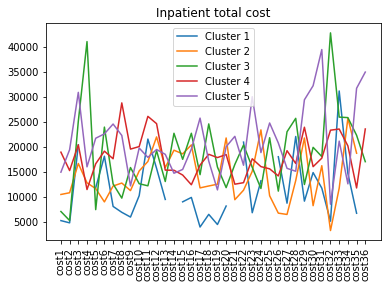

In [47]:
visual_cost_traj_by_cluster_by_claimtype('inpatient')

outpatient cost

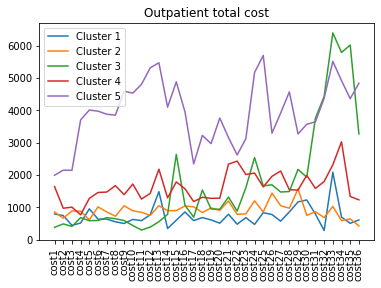

In [48]:
visual_cost_traj_by_cluster_by_claimtype('outpatient')

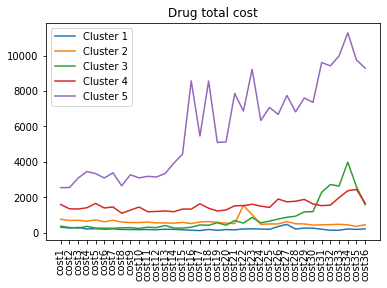

In [49]:
visual_cost_traj_by_cluster_by_claimtype('drug')

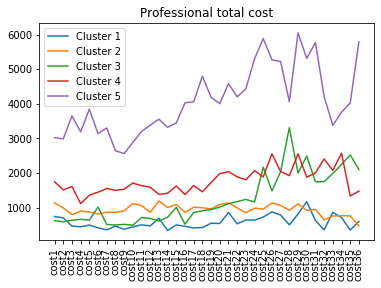

In [50]:
visual_cost_traj_by_cluster_by_claimtype('professional')

In [ ]:
for row in range(claim_traj_count.shape[0]):
    plt.plot(claim_traj_count.columns, claim_traj_count.iloc[row,:], label = "Cluster {}".format(row+1),color = color[row])


In [28]:
diff_type_cost[['total_cost_3a_inpatient', 'total_cost_3a_outpatient',
     'total_cost_3a_drug', 'total_cost_3a_professional']] = diff_type_cost[['total_cost_3a_inpatient', 'total_cost_3a_outpatient',
        'total_cost_3a_drug', 'total_cost_3a_professional']].fillna(0)

In [29]:
diff_type_cost.groupby('cluster_y').mean()

tma_acct  total_cost_3a_inpatient  total_cost_3a_outpatient  \
cluster_y                                                                    
1.0        31558.556701              7850.420669              10699.384965   
2.0        31679.170213             21768.451639              17210.591469   
3.0        34633.976744             45366.846202              31574.017268   
4.0        32016.947917             62874.144041              35288.315922   
5.0        29497.715385            101417.578181              72920.912673   

           total_cost_3a_drug  total_cost_3a_professional  
cluster_y                                                  
1.0               5175.028083                14336.568322  
2.0              16133.009834                26066.694583  
3.0              20996.555103                31990.499705  
4.0              42547.626892                49386.931994  
5.0             106342.157393                83190.535856

In [19]:
new = diff_type_cost.set_index(['tma_acct','cluster_y']).stack().reset_index()

In [20]:
new.cluster_y.unique()

array([ 2.,  5.,  4.,  1.,  3., nan])

In [35]:
px.box(x = 'level_2',y = 0, data_frame = new,color ='cluster_y',category_orders={"cluster_y": [1,2,3,4,5]})

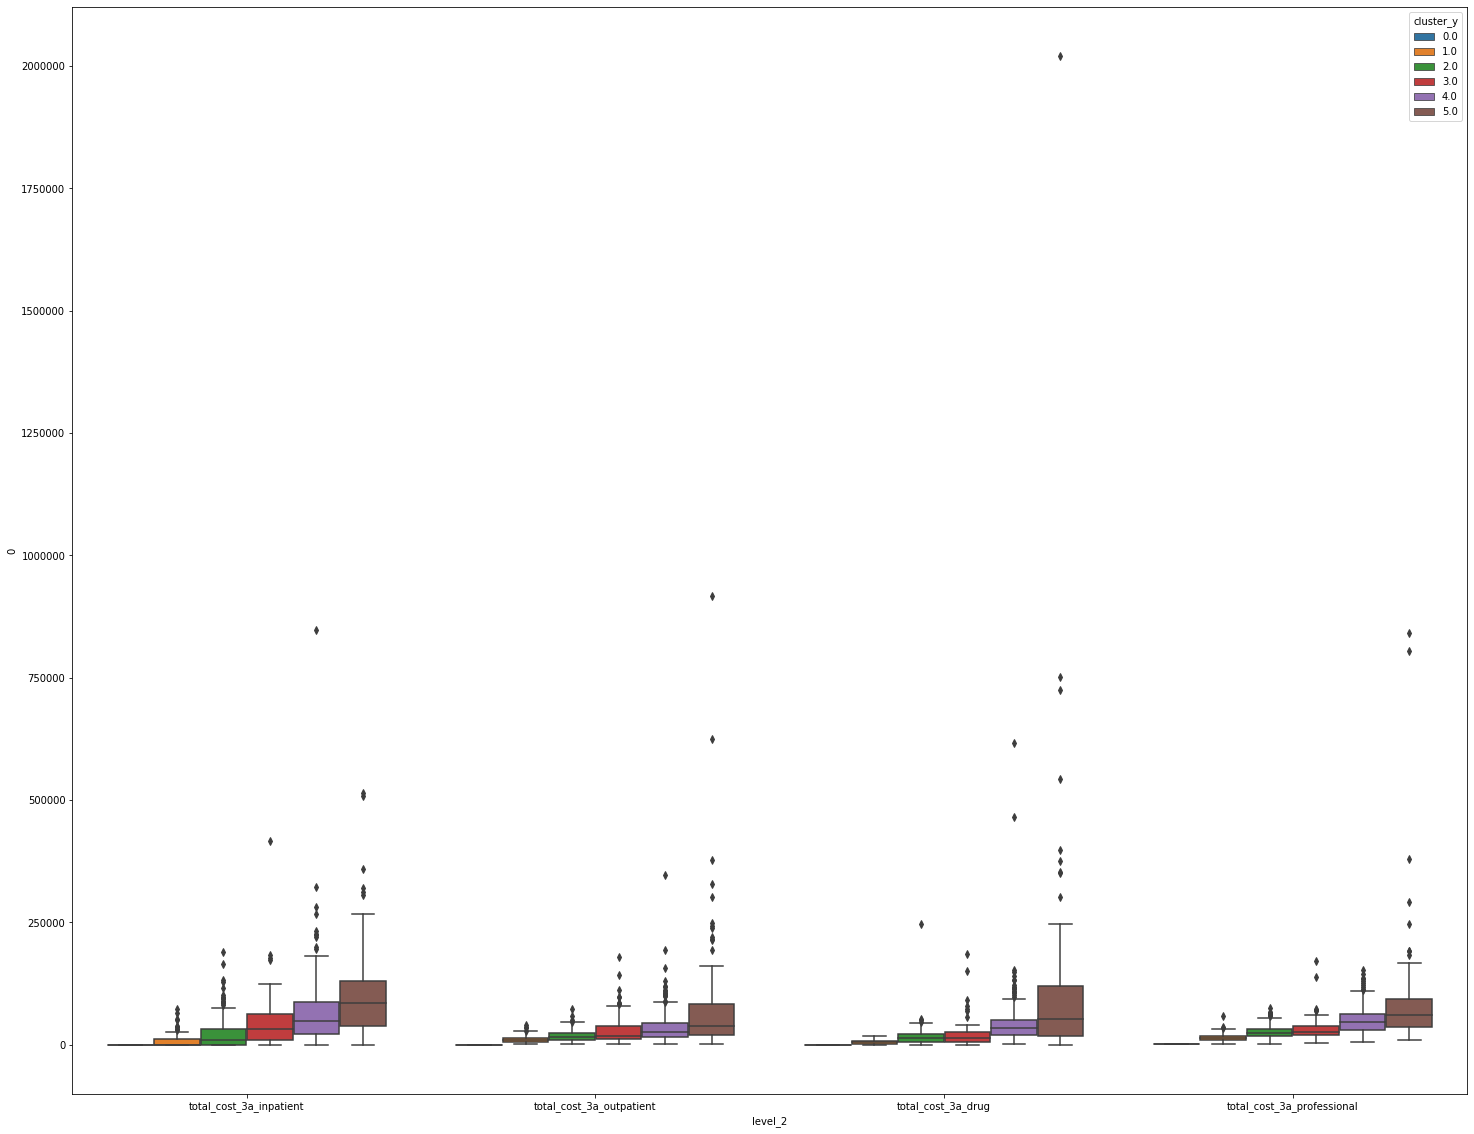

In [17]:
plt.figure(figsize=(25,20))
sns.boxplot(x = 'level_2',y = 0, data = new,hue ='cluster_y')

In [159]:
#diff_type_cost.drop(columns = [i for i in diff_type_cost.columns if re.search('cluster_',i)])


tma_acct  total_cost_3a_inpatient  total_cost_3a_outpatient  \
0         499             34658.357493              12683.149335   
1         757             27992.867968              18850.180330   
2        1025             25862.930321              30940.211386   
3        1088             27690.288337               9585.669845   
4        1150             59698.849627               4981.099384   
..        ...                      ...                       ...   
832     50621                      NaN              19113.579469   
833     50683            119501.581751             155981.246511   
834     50714             23846.356351             111096.307618   
835     50838             99365.836452             139705.903229   
836     50934             82077.615360             117929.548089   

     total_cost_3a_drug  total_cost_3a_professional  
0          11589.780377                24415.768796  
1          23095.899055                20222.971624  
2          23002.640183                42504.696335  
3           8571.010432                20102.370024  
4           7000.469928                25675.791182  
..                  ...                         ...  
832        38898.838959                20142.919935  
833       101997.756550               149403.976363  
834       184225.874932                32854.864237  
835       151722.898612                92340.675596  
836        66652.463588                92158.606395  

[837 rows x 5 columns]

# Draw Trajectory groupping trend

In [3]:
cd C:\Users\Joyqiao\Documents\CMU\RA\HIGHMARK Trajectory claim\HIghmark Project\data\stata_output

C:\Users\Joyqiao\Documents\CMU\RA\HIGHMARK Trajectory claim\HIghmark Project\data\stata_output


In [4]:
ls

 Volume in drive C is Windows
 Volume Serial Number is BA8F-7F5E

 Directory of C:\Users\Joyqiao\Documents\CMU\RA\HIGHMARK Trajectory claim\HIghmark Project\data\stata_output

01/13/2021  12:30 PM    <DIR>          .
01/13/2021  12:30 PM    <DIR>          ..
01/11/2021  02:39 PM            33,746 3a_331_total.jpg
01/11/2021  02:38 PM           878,483 3a_331_total_2021.xlsx
01/11/2021  02:24 PM           892,448 3a_3331_total_2021.xlsx
01/11/2021  02:35 PM               684 3a_3331_total_2021.xlsx_performance.csv
01/11/2021  02:26 PM            42,853 3a_33331_total.jpg
01/11/2021  02:26 PM           905,716 3a_33331_total_2021.xlsx
01/11/2021  02:36 PM               815 3a_33331_total_2021.xlsx_performance.csv
01/11/2021  02:44 PM         2,872,210 3a_33331_total_probupdates.xlsx
11/16/2020  09:44 AM         2,299,568 3a_drug_2121.xlsx
11/16/2020  09:47 AM               657 3a_drug_2121_performance.csv
11/16/2020  09:38 AM         2,640,599 3a_drug_31233.xlsx
11/16/2020  09:47 AM     

In [6]:
def get_traj_group_count(data):
    #select claim traj group columns
    claim_group_columns = [i for i in data.columns if re.search(r'_traj_Group',i)]
    claim_group_columns = claim_group_columns[1:] + [claim_group_columns[0]]
    claim_traj = data[claim_group_columns]

    claim_traj_count = pd.DataFrame()
    for i in range(1,data._traj_Group.nunique()+1):
        claim_traj_count = pd.concat([claim_traj_count,
                                      pd.DataFrame(np.array([(claim_traj == i).sum(axis = 0)]),index = [i])])

    return claim_traj,claim_traj_count

In [7]:
def visual_traj_converge_time(claim_traj_count):
    color = ['blue','red', 'green', 'orange','cyan']
    for row in range(claim_traj_count.shape[0]):
        plt.plot(claim_traj_count.columns, claim_traj_count.iloc[row,:], label = "Cluster {}".format(row+1),color = color[row])

    plt.xlabel('Quarter')
    # Set the y axis label of the current axis.
    plt.ylabel('Number of Patients')
    # Set a title of the current axes.
    plt.title('Patients Converge Time ')
    # show a legend on the plot
    plt.legend()
    # Display a figure.
    plt.show()

In [33]:
data = pd.read_excel('3b_33311_total_probupdates.xlsx')

In [34]:
data.head()

tma_acct     cost1     cost2     cost3     cost4     cost5     cost6  \
0       125  7.210501  6.749393  7.361947  7.747644  7.201723  6.348964   
1       214  8.056357  7.200850  8.621460  8.445317  8.261304  8.898891   
2       506  9.300526  7.252224  8.624338  6.730218  9.269092  9.797850   
3       665  4.584968       NaN       NaN       NaN  4.317488       NaN   
4       734  8.558330  8.704033  9.286122  8.426642  8.039793  8.908480   

      cost7     cost8     cost9    cost10     cost11    cost12    cost13  \
0  7.597291  9.689651  6.549350  6.800070   7.650183  9.135612  7.542213   
1  7.793488  7.816901  8.028866  7.934126   7.832950  8.366110  7.850224   
2  7.289201  9.073672  8.528288  7.101066  10.035251       NaN       NaN   
3  3.113071       NaN  2.555676       NaN   4.290460  7.312133  7.177859   
4  8.094971  7.753319  8.054164  8.631339   7.842605  6.639353  7.869826   

      cost14    cost15    cost16    cost17    cost18    cost19    cost20  \
0   6.789985  7.589791  6.977934  7.413627  6.832806  7.452762  6.901475   
1   7.550740  7.770312  7.419003  7.942334  7.504617  7.121438  8.272364   
2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3   6.564476  5.120147  7.318805  7.386731  5.471598  9.506177  7.928755   
4  10.498043  8.028067  7.816300  8.354764  8.357196  7.884373  7.873993   

     cost21    cost22    cost23    cost24     cost25    cost26    cost27  \
0  7.402226  8.913164  6.733640  7.732010   7.202959  6.534878  6.823155   
1  7.445494  7.455535  7.390144  7.717373   6.957250  7.709784  8.462299   
2       NaN       NaN       NaN       NaN        NaN       NaN       NaN   
3  7.552893  4.923115  4.296741       NaN        NaN       NaN       NaN   
4  7.282960  7.753139  7.816227  7.392118  10.518620  8.560032  8.295561   

     cost28    cost29     cost30    cost31    cost32    cost33    cost34  \
0  8.022270  9.069633   6.755070  7.622458  6.623374  7.507641  9.204880   
1  6.470165  7.701810  11.196735       NaN       NaN       NaN       NaN   
2       NaN       NaN        NaN       NaN       NaN       NaN       NaN   
3       NaN       NaN        NaN       NaN       NaN       NaN       NaN   
4  7.272120  7.416024   8.266453  8.463765  9.706784  8.946734  9.245609   

     cost35    cost36  time_1  time_2  time_3  time_4  time_5  time_6  time_7  \
0  7.111333  8.388334    0.25     0.5    0.75       1    1.25     1.5    1.75   
1       NaN       NaN    0.25     0.5    0.75       1    1.25     1.5    1.75   
2       NaN       NaN    0.25     0.5    0.75       1    1.25     1.5    1.75   
3       NaN       NaN    0.25     0.5    0.75       1    1.25     1.5    1.75   
4       NaN       NaN    0.25     0.5    0.75       1    1.25     1.5    1.75   

   time_8  time_9  time_10  time_11  time_12  time_13  time_14  time_15  \
0       2    2.25      2.5     2.75        3     3.25      3.5     3.75   
1       2    2.25      2.5     2.75        3     3.25      3.5     3.75   
2       2    2.25      2.5     2.75        3     3.25      3.5     3.75   
3       2    2.25      2.5     2.75        3     3.25      3.5     3.75   
4       2    2.25      2.5     2.75        3     3.25      3.5     3.75   

   time_16  time_17  time_18  time_19  time_20  time_21  time_22  time_23  \
0        4     4.25      4.5     4.75        5     5.25      5.5     5.75   
1        4     4.25      4.5     4.75        5     5.25      5.5     5.75   
2        4     4.25      4.5     4.75        5     5.25      5.5     5.75   
3        4     4.25      4.5     4.75        5     5.25      5.5     5.75   
4        4     4.25      4.5     4.75        5     5.25      5.5     5.75   

   time_24  time_25  time_26  time_27  time_28  time_29  time_30  time_31  \
0        6     6.25      6.5     6.75        7     7.25      7.5     7.75   
1        6     6.25      6.5     6.75        7     7.25      7.5     7.75   
2        6     6.25      6.5     6.75        7     7.25      7.5     7.75   
3        6     

In [35]:
pd.set_option('display.max_columns',None)
claim_traj,claim_traj_count = get_traj_group_count(data)
claim_traj_count

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
1   55  126  147  159  171  175  183  185  172  163  142  141  136  135  133   
2    0    0    0    0    0    0    0    3   20   31   49   56   62   64   73   
3  543  449  422  407  393  387  372  373  367  366  369  362  360  364  355   
4  313  317  311  305  298  296  295  284  285  283  284  288  289  283  285   
5   43   62   74   83   92   96  104  109  110  111  110  107  107  108  108   

    15   16   17   18   19   20   21   22   23   24   25   26   27   28   29  \
1  132  136  136  131  138  139  141  137  140  143  135  132  129  128  133   
2   75   73   75   86   81   79   75   82   81   79   85   89   90   95   89   
3  354  354  349  339  344  351  350  347  345  347  343  340  336  335  336   
4  285  283  288  293  285  278  282  282  283  280  287  289  294  291  291   
5  108  108  106  105  106  107  106  106  105  105  104  104  105  105  105   

    30   31   32   33   34   35  
1  135  138  132  134  131  133  
2   88   89   87   85   84   83  
3  335  331  339  336  339  337  
4  293  294  294  298  299  301  
5  103  102  102  101  101  100

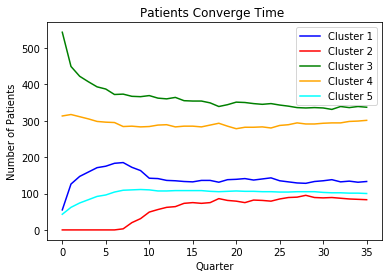

In [36]:
visual_traj_converge_time(claim_traj_count)

# Correct Rate

In [8]:
def get_traj_correct(data,claim_traj):
    claim_traj_correct = pd.DataFrame()
    for i in range(claim_traj.shape[1]):
        claim_traj_correct = pd.concat([claim_traj_correct,
                                     pd.DataFrame(claim_traj.iloc[:,i] == claim_traj.iloc[:,-1],columns = [i])],axis = 1)
    claim_traj_correct.iloc[:,-1] = True
    claim_traj_correct = pd.concat([claim_traj.iloc[:,-1],claim_traj_correct],axis = 1)
    claim_traj_correct_g = claim_traj_correct.groupby('_traj_Group').mean()
    return claim_traj_correct_g

In [9]:
def visual_correct_classfied_pct(claim_traj_correct_g):
    color = ['blue','red', 'green', 'orange','cyan']
    for row in range(claim_traj_correct_g.shape[0]):
        plt.plot(claim_traj_correct_g.columns, claim_traj_correct_g.iloc[row,:], label = "Cluster {}".format(row+1),color = color[row])

    plt.xlabel('Quarter')
    # Set the y axis label of the current axis.
    plt.ylabel('% of Correctly Classifed')
    # Set a title of the current axes.
    plt.title('Trajectory Converge Graph ')
    # show a legend on the plot
    plt.legend()
    # Display a figure.
    plt.show()

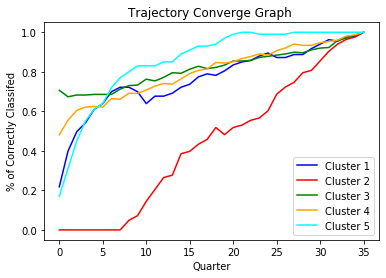

In [39]:
claim_traj_correct_g = get_traj_correct(data)
visual_correct_classfied_pct(claim_traj_correct_g)

In [10]:
#one step
def converge(data):
    claim_traj,claim_traj_count = get_traj_group_count(data)
    display(claim_traj_count)
    visual_traj_converge_time(claim_traj_count)
    claim_traj_correct_g = get_traj_correct(data,claim_traj)
    display(claim_traj_correct_g)
    visual_correct_classfied_pct(claim_traj_correct_g)

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
1   55  126  147  159  171  175  183  185  172  163  142  141  136  135  133   
2    0    0    0    0    0    0    0    3   20   31   49   56   62   64   73   
3  543  449  422  407  393  387  372  373  367  366  369  362  360  364  355   
4  313  317  311  305  298  296  295  284  285  283  284  288  289  283  285   
5   43   62   74   83   92   96  104  109  110  111  110  107  107  108  108   

    15   16   17   18   19   20   21   22   23   24   25   26   27   28   29  \
1  132  136  136  131  138  139  141  137  140  143  135  132  129  128  133   
2   75   73   75   86   81   79   75   82   81   79   85   89   90   95   89   
3  354  354  349  339  344  351  350  347  345  347  343  340  336  335  336   
4  285  283  288  293  285  278  282  282  283  280  287  289  294  291  291   
5  108  108  106  105  106  107  106  106  105  105  104  104  105  105  105   

    30   31   32   33   34   35  
1  135  138  132  134  131  133  
2   88   89   87   85   84   83  
3  335  331  339  336  339  337  
4  293  294  294  298  299  301  
5  103  102  102  101  101  100

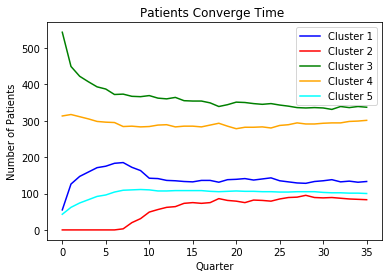

0         1         2         3         4         5   \
_traj_Group                                                               
1            0.218045  0.398496  0.496241  0.541353  0.609023  0.639098   
2            0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3            0.706231  0.673591  0.682493  0.682493  0.685460  0.685460   
4            0.481728  0.554817  0.604651  0.621262  0.624585  0.621262   
5            0.170000  0.310000  0.450000  0.550000  0.610000  0.640000   

                   6         7         8         9         10        11  \
_traj_Group                                                               
1            0.699248  0.721805  0.721805  0.699248  0.639098  0.676692   
2            0.000000  0.000000  0.048193  0.072289  0.144578  0.204819   
3            0.685460  0.712166  0.729970  0.732938  0.762611  0.753709   
4            0.664452  0.661130  0.691030  0.691030  0.707641  0.727575   
5            0.720000  0.770000  0.800000  0.830000  0.830000  0.830000   

                   12        13        14        15        16        17  \
_traj_Group                                                               
1            0.676692  0.691729  0.721805  0.736842  0.774436  0.789474   
2            0.265060  0.277108  0.385542  0.397590  0.433735  0.457831   
3            0.771513  0.795252  0.792285  0.813056  0.827893  0.816024   
4            0.740864  0.737542  0.764120  0.790698  0.807309  0.813953   
5            0.850000  0.850000  0.890000  0.910000  0.930000  0.930000   

                   18        19        20        21        22        23  \
_traj_Group                                                               
1            0.781955  0.804511  0.834586  0.849624  0.857143  0.879699   
2            0.518072  0.481928  0.518072  0.530120  0.554217  0.566265   
3            0.821958  0.833828  0.854599  0.854599  0.857567  0.872404   
4            0.847176  0.843854  0.850498  0.867110  0.877076  0.890365   
5            0.940000  0.970000  0.990000  1.000000  1.000000  0.990000   

                   24        25        26        27        28        29  \
_traj_Group                                                               
1            0.894737  0.872180  0.872180  0.887218  0.887218  0.917293   
2            0.602410  0.686747  0.722892  0.746988  0.795181  0.807229   
3            0.878338  0.884273  0.890208  0.899110  0.896142  0.910979   
4            0.883721  0.906977  0.920266  0.940199  0.933555  0.933555   
5            0.990000  0.990000  0.990000  1.000000  1.000000  1.000000   

                   30        31        32        33        34   35  
_traj_Group                                                         
1            0.939850  0.962406  0.954887  0.977444  0.977444  1.0  
2            0.855422  0.903614  0.939759  0.963855  0.975904  1.0  
3            0.919881  0.922849  0.958457  0.970326  0.985163  1.0  
4            0.946844  0.953488  0.960133  0.980066  0.986711  1.0  
5            1.000000  1.000000  1.000000  1.000000  1.000000  1.0

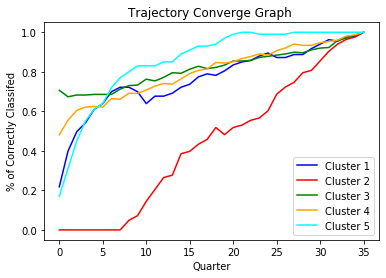

In [47]:
data = pd.read_excel('3b_33311_total_probupdates.xlsx')
converge(data)

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
1   11   30   52   58   59   58   59   59   61   58   67   64   63   64   61   
2  161  156  130  140  143  137  137  139  140  147  135  139  140  135  139   
3    0    0    0    2    5   10   19   18   27   34   42   47   48   50   49   
4  297  270  266  242  226  224  216  220  211  200  194  190  189  193  194   
5   52   65   73   79   88   92   90   85   82   82   83   81   81   79   78   

    15   16   17   18   19   20   21   22   23   24   25   26   27   28   29  \
1   58   60   60   59   58   60   60   61   59   60   55   55   54   53   53   
2  136  138  141  139  141  140  140  141  144  145  146  143  143  142  140   
3   49   47   40   42   42   42   43   43   45   44   48   51   52   53   58   
4  201  198  201  202  202  200  198  196  193  193  193  193  193  195  192   
5   77   78   79   79   78   79   80   80   80   79   79   79   79   78   78   

    30   31   32   33   34   35  
1   53   53   55   55   57   57  
2  140  143  141  141  140  144  
3   57   54   56   56   54   51  
4  191  192  189  189  190  189  
5   80   79   80   80   80   80

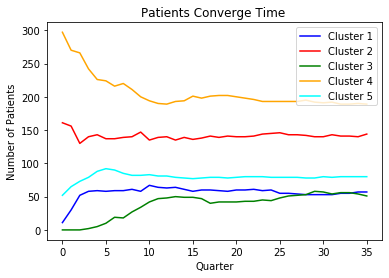

0         1         2         3         4         5   \
_traj_Group                                                               
1            0.052632  0.192982  0.385965  0.543860  0.561404  0.596491   
2            0.465278  0.493056  0.416667  0.527778  0.534722  0.548611   
3            0.000000  0.000000  0.000000  0.019608  0.039216  0.058824   
4            0.714286  0.698413  0.735450  0.735450  0.714286  0.719577   
5            0.337500  0.500000  0.650000  0.700000  0.775000  0.800000   

                   6         7         8         9         10        11  \
_traj_Group                                                               
1            0.614035  0.631579  0.649123  0.666667  0.771930  0.771930   
2            0.569444  0.590278  0.618056  0.673611  0.666667  0.680556   
3            0.137255  0.117647  0.235294  0.333333  0.470588  0.450980   
4            0.724868  0.772487  0.793651  0.820106  0.841270  0.841270   
5            0.800000  0.812500  0.850000  0.875000  0.900000  0.912500   

                   12        13        14        15        16        17  \
_traj_Group                                                               
1            0.842105  0.859649  0.859649  0.842105  0.877193  0.877193   
2            0.715278  0.722222  0.743056  0.756944  0.763889  0.777778   
3            0.470588  0.549020  0.568627  0.568627  0.549020  0.529412   
4            0.841270  0.873016  0.878307  0.910053  0.915344  0.941799   
5            0.912500  0.912500  0.925000  0.912500  0.925000  0.937500   

                   18        19        20        21        22        23  \
_traj_Group                                                               
1            0.894737  0.894737  0.894737  0.912281  0.912281  0.894737   
2            0.791667  0.805556  0.805556  0.812500  0.819444  0.854167   
3            0.607843  0.607843  0.627451  0.647059  0.666667  0.705882   
4            0.957672  0.973545  0.973545  0.973545  0.973545  0.973545   
5            0.950000  0.950000  0.962500  0.975000  0.975000  0.975000   

                   24        25        26        27        28        29  \
_traj_Group                                                               
1            0.912281  0.877193  0.912281  0.912281  0.912281  0.912281   
2            0.854167  0.875000  0.895833  0.909722  0.923611  0.902778   
3            0.666667  0.725490  0.803922  0.823529  0.882353  0.882353   
4            0.978836  0.984127  0.984127  0.984127  0.994709  0.984127   
5            0.975000  0.975000  0.975000  0.975000  0.975000  0.975000   

                   30        31        32        33        34   35  
_traj_Group                                                         
1            0.929825  0.929825  0.947368  0.964912  1.000000  1.0  
2            0.916667  0.944444  0.951389  0.965278  0.972222  1.0  
3            0.901961  0.921569  0.980392  1.000000  1.000000  1.0  
4            0.984127  0.989418  0.984127  0.994709  1.000000  1.0  
5            0.987500  0.987500  1.000000  1.000000  1.000000  1.0

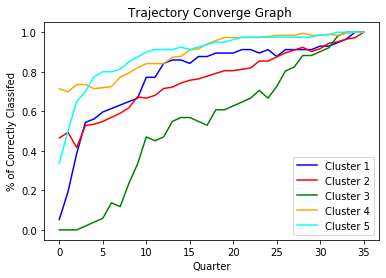

In [48]:
data = pd.read_excel('4_32321_total_probupdates.xlsx')
converge(data)

0    1    2    3    4    5    6    7    8    9   ...   26   27   28   29  \
1   64  112  145  152  160  142  132  131  119  109  ...  116  114  110  113   
2  222  247  242  247  247  251  256  254  241  236  ...  221  224  218  217   
3    0    0    0    0    1   17   26   31   51   65  ...   84   82   88   83   
4  514  408  360  341  317  312  305  297  298  297  ...  290  290  292  297   
5   44   77   97  104  119  122  125  131  135  137  ...  133  134  136  134   

    30   31   32   33   34   35  
1  107  108  107   99  102  101  
2  222  226  225  233  235  234  
3   88   84   85   88   83   83  
4  296  297  298  293  294  295  
5  131  129  129  131  130  131  

[5 rows x 36 columns]

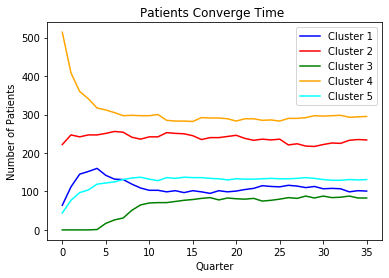

0         1         2         3         4         5   \
_traj_Group                                                               
1            0.227723  0.396040  0.564356  0.603960  0.643564  0.613861   
2            0.354701  0.427350  0.435897  0.474359  0.487179  0.517094   
3            0.000000  0.000000  0.000000  0.000000  0.012048  0.048193   
4            0.783051  0.691525  0.630508  0.644068  0.633898  0.667797   
5            0.129771  0.297710  0.412214  0.480916  0.610687  0.648855   

                   6         7         8         9   ...        26        27  \
_traj_Group                                          ...                       
1            0.603960  0.633663  0.603960  0.623762  ...  0.950495  0.950495   
2            0.529915  0.551282  0.555556  0.572650  ...  0.811966  0.829060   
3            0.048193  0.060241  0.156627  0.277108  ...  0.662651  0.662651   
4            0.654237  0.644068  0.694915  0.688136  ...  0.898305  0.901695   
5            0.656489  0.679389  0.740458  0.770992  ...  0.938931  0.938931   

                   28        29        30        31        32        33  \
_traj_Group                                                               
1            0.940594  0.940594  0.970297  0.990099  0.990099  0.950495   
2            0.824786  0.846154  0.871795  0.905983  0.918803  0.948718   
3            0.698795  0.686747  0.795181  0.819277  0.855422  0.903614   
4            0.918644  0.942373  0.955932  0.966102  0.979661  0.986441   
5            0.954198  0.961832  0.969466  0.961832  0.969466  0.992366   

                   34   35  
_traj_Group                 
1            1.000000  1.0  
2            0.982906  1.0  
3            0.951807  1.0  
4            0.993220  1.0  
5            0.992366  1.0  

[5 rows x 36 columns]

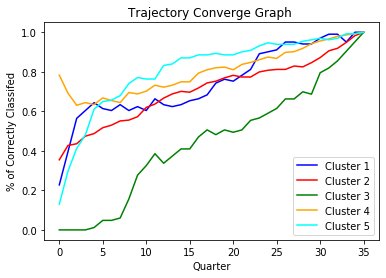

In [11]:
data = pd.read_excel('3a_33331_total_probupdates.xlsx')
converge(data)

In [21]:
#group by cross claim clincic trajectory
g = data.groupby(['_traj_Group_clinic','_traj_Group_claim'])

KeyError: '_traj_Group_clinic'

In [ ]:

def cal_count(count_feature,group):
    '''
    group: group 
    return list of list recording group size in the cross groups
    '''
    group_size = []
    clinic_claim_count = g[count_feature].count().reset_index()
    clinic_c = clinic_claim_count['_traj_Group_clinic'].nunique()

    for i in range(clinic_c):
        group_size.append(clinic_claim_count[clinic_claim_count['_traj_Group_clinic'] == i+1][count_feature].tolist())

    return group_size


In [ ]:
def visual_p(sizes):
    # Make figure and axes
    fig, axs = plt.subplots(2, 2,figsize=(20,15))

    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = ['very low cost','low cost','medium cost', 'high cost', 'very high cost' ]
    explode = (0.3, 0, 0, 0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')
    
    axs[0,0].pie(sizes[0], explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True)
    axs[0,0].set_title("Very High risk")

    axs[0,1].pie(sizes[1], explode=explode, labels=labels, autopct='%1.1f%%',
                 shadow=True)
    axs[0,1].set_title("High risk")
    axs[1,0].pie(sizes[2], explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True)
    axs[1,0].set_title("Medium risk")
    axs[1,1].pie(sizes[3], explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True)
    axs[1,1].set_title("Low risk")
    plt.show()
    


each group count

In [ ]:
group_size = cal_count('tma_acct',g)
visual_p(group_size)

In [ ]:
def visual_p(sizes):

    # Create subplots, using 'domain' type for pie charts
    specs = [[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]]
    fig = make_subplots(rows=2, cols=2, specs=specs)

    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = ['very low cost','low cost','medium cost', 'high cost', 'very high cost' ]

    # Define pie charts
    fig.add_trace(go.Pie(labels=labels, values=sizes[0], name='Very High risk'), 1, 1)
    fig.add_trace(go.Pie(labels=labels, values=sizes[1], name='High risk',
                        ),1, 2)
    fig.add_trace(go.Pie(labels=labels, values=sizes[2], name='Medium risk',
                        ),2, 1)
    fig.add_trace(go.Pie(labels=labels, values=sizes[3], name='"Low risk"',
                        ),2, 2)

    # Tune layout and hover info
    fig.update_traces(hoverinfo='label+percent+name', textinfo='none')
    fig.update(layout_title_text='Cost groups pie chart by clinical group',
               layout_showlegend=True)

    fig = go.Figure(fig)
    fig.show()
                  
visual_p(group_size)

Gender count each group

In [ ]:
long_format = data.set_index('tma_acct').stack().reset_index()
long_format = long_format[long_format['level_1'].isin([i for i in data.columns if re.search('cost',i)])].rename(columns = {0:'cost','level_1':'time'})
long_format.cost = long_format.cost.astype('float')
long_format = long_format.merge(data[['tma_acct','_traj_Group_clinic','_traj_Group_claim']].astype('category'),on = 'tma_acct',how = 'inner')
fig4 = px.scatter(long_format,'time','cost',color = '_traj_Group_claim',category_orders={'_traj_Group_claim':[5,4,3,2,1]},
                  color_discrete_sequence=['rgb(103,0,31)','rgb(214,96,77)','rgb(253,219,199)','rgb(209,229,240)'])

fig4.show()

In [ ]:
fig4 = px.scatter(long_format,'time','cost',color = '_traj_Group_clinic',category_orders={'_traj_Group_clinic':[1,2,3,4]},  color_discrete_sequence=['rgb(103,0,31)','rgb(214,96,77)','rgb(253,219,199)','rgb(209,229,240)'])
fig4.show()

In [ ]:
long_format['cost']  = np.exp(long_format.cost)


In [ ]:
def visual_cross_traj_cluster_cost_line(clinic_traj,claim_traj):

    cross_cluster = data[(data['_traj_Group_clinic'] == clinic_traj)&(data['_traj_Group_claim'] == claim_traj)]
    fig = px.line(long_format[long_format['tma_acct'].isin(cross_cluster.tma_acct)],'time','cost',color = 'tma_acct')
    fig.show()
    
    return cross_cluster

In [ ]:
veryh_egfr_low_cost = visual_cross_traj_cluster_cost_line(1,1)

In [ ]:
veryh_egfr_high_cost= visual_cross_traj_cluster_cost_line(1,5)

In [ ]:
veryl_risk_high_cost = visual_cross_traj_cluster_cost_line(4,5)
#veryl_risk_high_cost.to_csv(basepath+'\\data\\cross_walk_investigation\\veryl_risk_high_cost.csv')

# investigate in specific patient

In [ ]:
basepath = r'C:\Users\Joyqiao\Documents\CMU\RA\HIGHMARK Trajectory claim\HIghmark Project'
import os
os.chdir(basepath+'\data\\cleaned_data')
max_l = pd.read_csv('max_min_patient.csv')['max']
def find_tma(tma):
    find = False
    i = 0
    while find == False:
        tma_max = max_l[i]
        if tma <= tma_max:
            data = pd.read_csv('cleaned_{}.csv'.format(i))

            if tma in data['TMA_Acct']:
                records= data[data['TMA_Acct']==tma]
                find = True
            else:
                data = pd.read_csv('cleaned_16.csv')
                records= data[data['TMA_Acct']==tma]
                find = True
        else:
            i+=1
    return records

In [ ]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [ ]:
tma_28771 = find_tma(28771)
tma_28771
fig5 = px.scatter(tma_28771,x = 'icrd_dt_deidentified',y = 'eacl_prv_alcrg_at')
fig5.show()

In [ ]:
tma_2305 = find_tma(2305)
fig5 = px.scatter(tma_2305,x = 'icrd_dt_deidentified',y = 'eacl_prv_alcrg_at')
fig5.show()

In [ ]:
tma_34540 = find_tma(34540)
fig5 = px.scatter(tma_34540,x = 'icrd_dt_deidentified',y = 'eacl_prv_alcrg_at')
fig5.show()

veryh_egfr_high_cost = data[(data['_traj_Group_clinic'] == 1)&(data['_traj_Group_claim'] == 4)]
fig4 = px.line(long_format[long_format['tma_acct'].isin(veryh_egfr_high_cost.tma_acct)],'time','cost',color = 'tma_acct')
fig4.show()

In [ ]:
tma_31302 = find_tma(31302)
fig5 = px.scatter(tma_31302,x = 'icrd_dt_deidentified',y = 'eacl_prv_alcrg_at')
fig5.show()
tma_31302[tma_31302['eacl_prv_alcrg_at']>40000]

In [ ]:
tma_49267= find_tma(49267)
fig5 = px.scatter(tma_49267,x = 'icrd_dt_deidentified',y = 'eacl_prv_alcrg_at')
fig5.show()
tma_49267[tma_49267['eacl_prv_alcrg_at']>4000]

In [ ]:
veryl_risk_high_cost = data[(data['_traj_Group_clinic'] == 4)&(data['_traj_Group_claim'] == 5)]
fig4 = px.line(long_format[long_format['tma_acct'].isin(veryl_risk_high_cost.tma_acct)],'time','cost',color = 'tma_acct')
fig4.show()



In [ ]:

long_format.groupby(['_traj_Group_clinic','_traj_Group_claim'])['cost'].mean()

In [ ]:
#data['cost_max'] = data[[i for i in data.columns if re.search(r"cost",i)]].max(axis = 1)
#data['cost_min'] = data[[i for i in data.columns if re.search(r"cost",i)]].min(axis = 1)

## age difference across clusters

In [ ]:
fig2 = px.box(data, x="_traj_Group_clinic", y="age_in_2010" )
fig2.show()

In [ ]:
fig3 = px.box(data, x="_traj_Group_clinic", y="age_in_2010",color="_traj_Group_claim",facet_col = '_traj_Group_claim'
    ,category_orders={"_traj_Group_claim": [1,2,3,4]})

fig3.show()

# transplant_dialysis patient investigation

In [9]:
transplant = pd.read_csv(basepath+'\data\sorted_data\\transplant_patient_clean.csv',index_col = 0)
dialysis = pd.read_csv(basepath+'\data\sorted_data\\dialysis_patient_clean.csv',index_col = 0)


In [10]:
transplant.rename(columns = {'0':'TMA_Acct','1':'icrd_dt_deidentified','2':'code'},inplace = True)
dialysis.rename(columns = {'0':'TMA_Acct','1':'icrd_dt_deidentified','2':'code'},inplace = True)

In [11]:
transplant_init = transplant.sort_values(by = ['TMA_Acct','icrd_dt_deidentified']).drop_duplicates(subset = 'TMA_Acct',keep = 'first')
dialysis_init = dialysis.sort_values(by = ['TMA_Acct','icrd_dt_deidentified']).drop_duplicates(subset = 'TMA_Acct',keep = 'first')


In [12]:
def merge_initial_egfr_stage(df):
    
    df['date'] = pd.to_datetime('1/1/2010') + pd.to_timedelta(np.ceil(df.icrd_dt_deidentified), unit="D")
    initial_kidney_egfr = pd.read_csv('{}\Clinical Data\Clinical Data\egfr_earliest.csv'.format(basepath),index_col = 0)
    df = df.merge(initial_kidney_egfr,on = 'TMA_Acct',how = 'left')
    df['stage'] = df['stage'].fillna('Unknown')

    print(df.shape)
    return df


In [13]:

merge_initial_egfr_stage(transplant_init)

(70, 7)


TMA_Acct  icrd_dt_deidentified   code       date       egfr    stage  \
0        601                  2277    652 2016-03-27  20.000000        4   
1       4167                  2115    652 2015-10-17  13.016144        5   
2       4429                  1207    652 2013-04-22        NaN  Unknown   
3       4916                  3333    652 2019-02-16  19.000000        4   
4       5570                   610    652 2011-09-03  10.739767        5   
..       ...                   ...    ...        ...        ...      ...   
65     47207                   938    652 2012-07-27        NaN  Unknown   
66     49073                  3269    652 2018-12-14        NaN  Unknown   
67     49116                  2976    652 2018-02-24  60.000000        2   
68     49249                  3403    652 2019-04-27        NaN  Unknown   
69     50352                  3494  50360 2019-07-27   8.000000        5   

           min  
0   2010-02-23  
1   2010-07-27  
2          NaN  
3   2014-02-01  
4   2010-01-12  
..         ...  
65         NaN  
66         NaN  
67  2010-02-02  
68         NaN  
69  2014-08-13  

[70 rows x 7 columns]

In [14]:
transplant = merge_initial_egfr_stage(transplant)
dialysis = merge_initial_egfr_stage(dialysis)
dialysis

(70, 7)
(938, 7)


TMA_Acct  icrd_dt_deidentified   code       date       egfr    stage  \
0         503                  1756  V4511 2014-10-23  17.769712        4   
1         506                  1020  V4511 2012-10-17  36.279396       3b   
2         552                    14  V4511 2010-01-15        NaN  Unknown   
3         586                  1029  V4511 2012-10-26  24.044212        4   
4         601                  1377  V4511 2013-10-09  20.000000        4   
..        ...                   ...    ...        ...        ...      ...   
933     50621                  2584   Z992 2017-01-28  53.000000       3a   
934     50838                  3377   Z992 2019-04-01  52.000000       3a   
935     50449                  2903   Z992 2017-12-13        NaN  Unknown   
936     50534                  2179   Z992 2015-12-20        NaN  Unknown   
937     50763                  2648   Z992 2017-04-02        NaN  Unknown   

            min  
0    2010-02-08  
1    2009-11-02  
2           NaN  
3    2010-01-21  
4    2010-02-23  
..          ...  
933  2012-09-20  
934  2012-02-02  
935         NaN  
936         NaN  
937         NaN  

[938 rows x 7 columns]

In [15]:
transplant_c = transplant.groupby(['stage'])['TMA_Acct'].count().reset_index()
transplant_c

stage  TMA_Acct
0        1         2
1        2         5
2       3a         5
3       3b         7
4        4        16
5        5        18
6  Unknown        17

In [16]:
dialysis_c = dialysis.groupby(['stage'])['TMA_Acct'].count().reset_index()
dialysis_c

stage  TMA_Acct
0        1        23
1        2        62
2       3a        85
3       3b       139
4        4       195
5        5       143
6  Unknown       291

In [17]:
r = px.colors.sequential.RdBu[6:0:-1] + [px.colors.sequential.RdBu[7]]
fig1 = go.Figure(data=[go.Pie(values = transplant_c['TMA_Acct'],labels = transplant_c['stage']
                              ,sort = False
                              ,marker=dict(colors=r))])
             
fig1.show()
fig1.write_html(basepath+"\\data\\visuals\\transplant_count.html")

In [18]:
r = px.colors.sequential.RdBu[6:0:-1] + [px.colors.sequential.RdBu[7]]
fig1 = go.Figure(data=[go.Pie(values = dialysis_c['TMA_Acct'],labels = dialysis_c['stage']
                              ,sort = False
                              ,marker=dict(colors=r))])
fig1.show()
fig1.write_html(basepath+"\\data\\visuals\\transplant_count.html")

In [ ]:
,color = 'stage',
              color_discrete_map=dict(zip(['1','2','3a','3b','4','5'],[r[i] for i in range(6,0,-1)]))

In [ ]:
transplant_3a = transplant.merge(data,left_on  = 'TMA_Acct',right_on = 'tma_acct',how = 'inner')
fig = px.scatter(transplant_3a, y="_traj_Group_claim", x="_traj_Group_clinic", 
              hover_data=['TMA_Acct'])
fig.show()

In [ ]:
with open(basepath+"\\data\\visuals\\transplant_count.html", 'a') as f:
    f.write(fig1.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig2.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig3.to_html(full_html=False, include_plotlyjs='cdn'))

In [ ]:
transplant_3a[["_traj_Group_claim","_traj_Group_clinic"]]

In [ ]:
transplant_3b = transplant.merge(data,left_on  = 'TMA_Acct',right_on = 'tma_acct',how = 'inner')


In [ ]:
transplant_3a.columns

In [ ]:
initial_kidney_egfr = pd.read_csv('{}\Clinical Data\Clinical Data\egfr_earliest.csv'.format(basepath),index_col = 0)
initial_kidney_egfr